#### Set up packegs

In [5]:
import os 
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
import numpy as np
import chess
import chess.engine 
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'


#### Add path to chess file, read in data

In [2]:
#stockfish_path = "/Users/jeremiahomeike/Desktop/PSY454/final_proj/stockfish/15/bin/stockfish"
#chess_csv_file = '/Users/jeremiahomeike/Desktop/PSY454/final_proj/lichess_db_standard_rated_2019-01.csv.bz2'

stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"
chess_data_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Data'
chess_csv_file = 'lichess_db_standard_rated_2019-01.csv'
chess_csv_file = os.path.join(chess_data_folder,chess_csv_file)

#### Read in X rows of data

In [110]:
data_raw = pd.read_csv(chess_csv_file, nrows=1000000)
data_raw.head()

/var/folders/s3/06m5bv8s03v5c2y_thvlc6qr0000gp/T/ipykernel_6368/3524454987.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(chess_csv_file, nrows=1000000)


,game_id,type,result,white_player,black_player,white_elo,black_elo,time_control,num_ply,termination,white_won,black_won,no_winner,move_ply,move,cp,cp_rel,cp_loss,is_blunder_cp,winrate,winrate_elo,winrate_loss,is_blunder_wr,opp_winrate,white_active,active_elo,opponent_elo,active_won,is_capture,clock,opp_clock,clock_percent,opp_clock_percent,low_time,board,active_bishop_count,active_knight_count,active_pawn_count,active_queen_count,active_rook_count,is_check,num_legal_moves,opp_bishop_count,opp_knight_count,opp_pawn_count,opp_queen_count,opp_rook_count
0,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,0,e2e4,0.1,0.10,-0.02,False,0.5295,0.4758,0.0000,False,0.5244,True,1702,1628,False,False,600.0,600.0,0.000,0.000,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2,2,8,2,2,0,20,2,2,8,2,2
1,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,1,e7e5,0.12,-0.12,0.25,False,0.5244,0.4456,0.0192,False,0.5295,False,1628,1702,True,False,600.0,600.0,0.000,0.000,False,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,3,2,8,2,2,0,20,2,2,8,2,2
2,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,2,g1f3,0.37,0.37,0.14,False,0.5749,0.4994,0.0084,False,0.5052,True,1702,1628,False,False,598.0,600.0,0.003,0.000,False,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,2,2,8,2,2,0,29,2,2,8,2,2
3,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,3,b8c6,0.23,-0.23,-0.08,False,0.5134,0.4456,-0.0109,False,0.5664,False,1628,1702,True,False,599.0,598.0,0.002,0.003,False,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,3,2,8,2,2,0,29,2,2,8,2,2
4,mAEz2AcC,Rapid,0-1,AliKhaled,ifospor,1702,1628,600+0,36,Normal,False,True,False,4,f1c4,0.15,0.15,0.05,False,0.5295,0.4758,0.0000,False,0.5244,True,1702,1628,False,False,596.0,599.0,0.007,0.002,False,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,2,2,8,2,2,0,27,2,2,8,2,2


#### Get 600+0 games and add RT

In [111]:
# what game types do we care about? filter dataframe to only include these time-control settings (these occur on first page) - new name for df is data_filt
game_time_types = ['600+0']

# filter based on if it's in these game settings... 
data_filt = data_raw.loc[data_raw.time_control.isin(game_time_types)].reset_index(drop = True)

# remove first move of each player (this is the first two move_plys - half-moves - of the game)
def filter_moves(game_data):
    filt_game_data = game_data.loc[game_data.move_ply > 2].reset_index(drop = True)
    return filt_game_data


# compute rt for each move, add this to the dataframe (new name - data_rt)
def add_rt(game_df):
    
    game_df = game_df.reset_index(drop = True)
    game_time_setting = game_df.time_control[0] # this is the time_control (no clue what the 0 index is doing here)
    time_back = 0

    if '+1' in game_time_setting:
        time_back = 1
    elif '+2' in game_time_setting:
        time_back = 2
    elif '+3' in game_time_setting:
        time_back = 3
    elif '+5' in game_time_setting:
        time_back = 5
    elif '+10' in game_time_setting:
        time_back = 10
    elif '+20' in game_time_setting:
        time_back = 20
    
    white_move_rts = time_back + game_df.loc[game_df.white_active == True, 'clock'].diff()*-1
    black_move_rts = time_back + game_df.loc[game_df.white_active == False, 'clock'].diff()*-1
    game_df.loc[game_df.white_active == True, 'rt'] = white_move_rts
    game_df.loc[game_df.white_active == False, 'rt'] = black_move_rts
    
    return game_df
    
data_rt = data_filt.groupby('game_id').apply(add_rt).reset_index(drop = True) # this is the data with move times
data_rt = data_rt.groupby('game_id').apply(filter_moves).reset_index(drop=True)
data_rt.head()

,game_id,type,result,white_player,black_player,white_elo,black_elo,time_control,num_ply,termination,white_won,black_won,no_winner,move_ply,move,cp,cp_rel,cp_loss,is_blunder_cp,winrate,winrate_elo,winrate_loss,is_blunder_wr,opp_winrate,white_active,active_elo,opponent_elo,active_won,is_capture,clock,opp_clock,clock_percent,opp_clock_percent,low_time,board,active_bishop_count,active_knight_count,active_pawn_count,active_queen_count,active_rook_count,is_check,num_legal_moves,opp_bishop_count,opp_knight_count,opp_pawn_count,opp_queen_count,opp_rook_count,rt
0,01kclCQw,Rapid,0-1,yazdi-96,ahmedib77,1314,1262,600+0,52,Normal,False,True,False,3,e7e6,0.18,-0.18,0.04,False,0.5244,0.4490,0.0109,False,0.5295,False,1262,1314,True,False,599.0,597.0,0.002,0.005,False,rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBN...,3,2,8,2,2,0,22,2,2,8,2,2,1.0
1,01kclCQw,Rapid,0-1,yazdi-96,ahmedib77,1314,1262,600+0,52,Normal,False,True,False,4,b1c3,0.22,0.22,0.07,False,0.5664,0.4856,0.0369,False,0.5134,True,1314,1262,False,False,588.0,599.0,0.020,0.002,False,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/8/PP2PPPP/RNBQKB...,2,2,8,2,2,0,30,2,2,8,2,2,9.0
2,01kclCQw,Rapid,0-1,yazdi-96,ahmedib77,1314,1262,600+0,52,Normal,False,True,False,5,d7d5,0.15,-0.15,0.20,False,0.5244,0.4490,0.0192,False,0.5295,False,1262,1314,True,False,597.0,588.0,0.005,0.020,False,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/2N5/PP2PPPP/R1BQ...,3,2,8,2,2,0,28,2,2,8,2,2,2.0
3,01kclCQw,Rapid,0-1,yazdi-96,ahmedib77,1314,1262,600+0,52,Normal,False,True,False,6,g1f3,0.35,0.35,0.21,False,0.5749,0.4947,0.0453,False,0.5052,True,1314,1262,False,False,571.0,597.0,0.048,0.005,False,rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/2N5/PP2PPPP/R1B...,2,2,8,2,2,0,33,2,2,8,2,2,17.0
4,01kclCQw,Rapid,0-1,yazdi-96,ahmedib77,1314,1262,600+0,52,Normal,False,True,False,7,c7c5,0.14,-0.14,0.03,False,0.5244,0.4490,0.0000,False,0.5295,False,1262,1314,True,False,594.0,571.0,0.010,0.048,False,rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/2N2N2/PP2PPPP/R...,3,2,8,2,2,0,32,2,2,8,2,2,3.0


#### Add functions for dealing with stockfish scoring

In [112]:
# for cp to wp
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cp_to_wp(score_val_cp_white):
    """
    Converts centipawn score val (signed with white pos/black neg) to win prob for white
    
    Args:
        score_val_cp_white: centipawn value (signed with white positive black negative) for position
    Returns:
        win probability: measure between 0 and 1 giving probability of white win
        Note: taken for logistic regression model applied to predict win given centipawn games
    """
    this_const = -0.045821224987387915
    this_board_score_val = 0.002226678310106879
    #return sigmoid(log_reg_cp.params['const'] + log_reg_cp.params['board_score_val']*score_val_cp_white)
    return sigmoid(this_const + this_board_score_val*score_val_cp_white)

def mate_to_wp(score_val_mate):
    """
    Converts plys from mate to win prob (for the player who is within reach of mate)
    """
    # return sigmoid(log_reg_mate.params['const'] + log_reg_mate.params['score_val_pos']*np.abs(score_val_mate))
    return sigmoid(3.6986223572286208 + -0.05930670977061789*np.abs(score_val_mate))


# add support for if mate == 0!!!!!!!
def process_score(this_score, white_active):
    """
    Input:
    this score:  what is returned from stockfish
    white active: is whether it is white's move
    
    Output:
    score_dict: contains
    """
    
    white_score = this_score.white() # gets the score from perspective of the white player 
    is_mate = white_score.is_mate()
    
    if is_mate:
        score_type = 'mate'
        score_val = white_score.mate() # this is framed as white'
        if score_val > 0: # White is closer to the math 
            wp = mate_to_wp(score_val) # this is framed as whichever side is close to mate
        elif score_val < 0: # Black is closer to the mate
            wp = 1 - mate_to_wp(score_val)
        elif score_val == 0: #TODO: For score_val = 0, we don't know which side is closer to the mate. white_active tells us # just get rid of these rows?
            wp = 1 if white_active else 0
            # 1 or -1 depending on whose move this is.... so process score needs to take in who is active
    else: # centipawn...
        score_type = 'cp'
        score_val = white_score.score()
        wp = cp_to_wp(score_val)
    
    wp_active = wp if white_active else 1 - wp
        
    #score_dict = {'type': score_type, 'val': score_val, 'wp': wp}
    return wp_active


#### Function to get board evaluation at multiple depths (as well as move suggestions at multiple depths)

In [113]:
def run_engine_analysis_on_depths(depths, board, engine):

    """ 
    Inputs:
        Depths: list of depths at which we want a stockfish valuation (and move suggestion)
        Board: python-chess board representation of positin to-be evaluated (contains whose move it is as well)
        engine: stockfish engine, python-chess intialized
    Outputs:
        moves_at_depths: move suggestion at each search depth - note that this will be only filled in if moves are availablew (e.g. not a mate situation)
        scores_at_depths: score for each depth
    """

    engine.configure({"Clear Hash": None})

    max_depth = max(depths)
    
    scores_at_depths = []
    moves_at_depths = []
    
    
    # check for stalemate
    if current_board.is_stalemate():
        info = engine.analyse(current_board, chess.engine.Limit(time=0.001))

    
    last_depth = 0

    with engine.analysis(board, multipv=1) as analysis:
            
        for info in analysis:
            # print(info)

            this_depth = info.get("depth", 0)
            this_score = info.get("score")
            this_pv = info.get("pv")

            if (this_score != None):
                
                # handle mate situation... 
                if this_score.is_mate():
                    # append the mate to the rest of the list repeatedly...
                    n_depths_remaining = len(depths) - len(scores_at_depths)
                    scores_at_depths = [*scores_at_depths, *[this_score]*n_depths_remaining]
                    break
            
                # otherwise append
                if (this_depth in depths):
                    # look for repeats of depth - this means a research and we should replace the previous answer w/ the new one
                    if this_depth == last_depth:
                        scores_at_depths = scores_at_depths[:-1]
                    
                    scores_at_depths.append(this_score)
                    if this_pv != None:
                        moves_at_depths.append(this_pv[0])
                                    
            if (this_depth >= max_depth):
                break
                
    return scores_at_depths, moves_at_depths

In [114]:
len(data_rt.game_id.unique())

2932

#### Loop through games / moves and get quality of each move made
Create resultant DF which lines up quality of last move (made by opponent) with rt nad other info for this move

In [116]:
## Just loop through a game and get the moves
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

# What depths to include?
depths = range(1,7)
n_depths = len(depths)

depths_to_record = range(2,7)

# loop through games...
game_ids = data_rt.game_id.unique()

# put resultant dfs into a list
res_dfs = []

# go through 10 games
n_games = 2500

for game_idx in range(n_games):
    
    print('Starting game {}'.format(game_idx))

    this_game_id = game_ids[game_idx]

    game_df = data_rt.loc[data_rt.game_id == this_game_id].reset_index(drop=True)
    n_moves = game_df.shape[0]

    # make a numpy array to hold the scores
    game_scores_for_white = np.zeros((n_moves,n_depths))

    for move_idx in range(n_moves):
        this_row = game_df.loc[move_idx,:]

        this_board_state = this_row.board
        this_white_active = this_row.white_active
        player_to_move = "white" if this_white_active else "black"
        this_row_move = this_row.move

        current_board = chess.Board(this_board_state)

        scores_at_depths, _ = run_engine_analysis_on_depths(depths, current_board, engine)

        game_scores_for_white[move_idx,:] = [process_score(this_score, True) for this_score in scores_at_depths]

    # we can take move quality for white (how good move was for white) by just taking difference in board evaluation for white between successive moves
    move_quality_for_white = game_scores_for_white[1:,:-1] - game_scores_for_white[:-1,1:]
    # same for black - note black score is 1 minus score for white
    move_quality_for_black = (1 - game_scores_for_white[1:,:-1]) - (1 - game_scores_for_white[:-1,1:])

    # now get move quality by taking move quality for white for white moves and move quality for black for black moves
    white_active = game_df['white_active'].values[:-1]
    move_quality = move_quality_for_white
    move_quality[white_active == False] = move_quality_for_black[white_active == False]

    # make a dataframe where we assign this to be the quality of the 'last' move, made by the opponent... this just means line it up with other move information one move forward in time
    df_columns = ['Last_Move_Quality_Depth_{}'.format(d) for d in depths_to_record]
    game_res_df = pd.DataFrame(move_quality, columns = df_columns)
    game_res_df['white_active'] = game_df['white_active'][1:].reset_index(drop=True)
    game_res_df['game_id'] = game_df['game_id'][1:].reset_index(drop=True)
    game_res_df['move_ply'] = game_df['move_ply'][1:].reset_index(drop=True)
    game_res_df['rt'] = game_df['rt'][1:].reset_index(drop=True)
    game_res_df['move'] = game_df['move'][1:].reset_index(drop=True)
    
    # append to list of resultant dfs
    res_dfs.append(game_res_df)

Starting game 0
Starting game 1
Starting game 2
Starting game 3
Starting game 4
Starting game 5
Starting game 6
Starting game 7
Starting game 8
Starting game 9
Starting game 10
Starting game 11
Starting game 12
Starting game 13
Starting game 14
Starting game 15
Starting game 16
Starting game 17
Starting game 18
Starting game 19
Starting game 20
Starting game 21
Starting game 22
Starting game 23
Starting game 24
Starting game 25
Starting game 26
Starting game 27
Starting game 28
Starting game 29
Starting game 30
Starting game 31
Starting game 32
Starting game 33
Starting game 34
Starting game 35
Starting game 36
Starting game 37
Starting game 38
Starting game 39
Starting game 40
Starting game 41
Starting game 42
Starting game 43
Starting game 44
Starting game 45
Starting game 46
Starting game 47
Starting game 48
Starting game 49
Starting game 50
Starting game 51
Starting game 52
Starting game 53
Starting game 54
Starting game 55
Starting game 56
Starting game 57
Starting game 58
Startin

In [117]:
res_df = pd.concat(res_dfs, ignore_index = True)

In [3]:
res_df.to_csv('Depth_7_2500_games.csv')

NameError: name 'res_df' is not defined

### Plot relationship between last move quality and RT

In [4]:
res_df = pd.read_csv('Depth_7_2500_games.csv')



NameError: name 'pd' is not defined

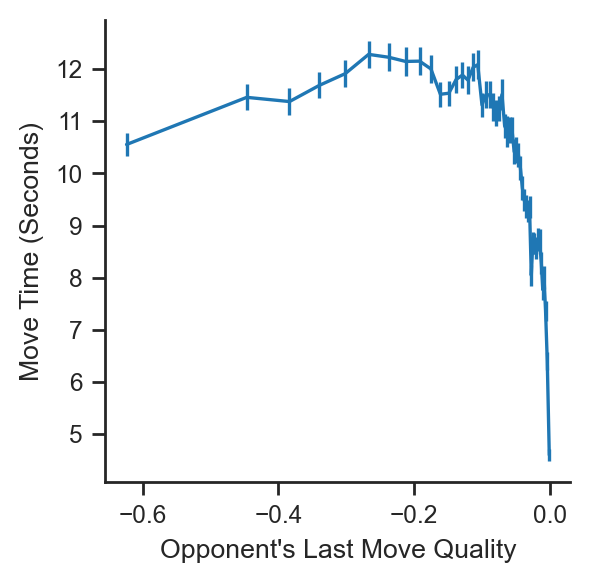

In [10]:
res_df = pd.read_csv('Depth_7_2500_games.csv')

sns.set_style("ticks")

sns.set_context('paper')

fig,ax = plt.subplots(1, figsize=(3,3), dpi=200)

depths_to_plot = [2]

# bin and get the mean
for depth_number in depths_to_plot:

    this_col = 'Last_Move_Quality_Depth_{}'.format(depth_number)
    this_col_bin_name = this_col + '_bin'

    def get_midpoints(x):
        return (x[1:] + x[:-1]) / 2

    n_bin_bounds = 50
    # bin_bounds = np.linspace(-.2,.2,n_bin_bounds)
    bin_bounds = np.unique(np.percentile(res_df[this_col],np.arange(0,100,100/n_bin_bounds)))#np.linspace(-.001,.05,n_bin_bounds)
    #bin_bounds = np.append(bin_bounds,1)
    #bin_bounds = np.insert(bin_bounds,0,-1)

    #bin_bounds = np.insert(bin_bounds,0, -1)
    bin_labels = get_midpoints(bin_bounds)
    bin_labels
    #bin_labels[0] = -.3
    res_df[this_col_bin_name] = pd.cut(res_df[this_col], bin_bounds, labels=bin_labels)

    agg_df = res_df.groupby(this_col_bin_name).agg({'rt': ['mean', 'count', 'std'], this_col: 'mean'}).reset_index()

    ax.errorbar(agg_df[this_col]['mean'], agg_df['rt']['mean'], yerr = agg_df['rt']['std']/np.sqrt(agg_df['rt']['count']), label = '{}'.format(depth_number - 1))
    #ax.plot(agg_df[this_col]['mean'], agg_df['rt']['mean'],'o', ms = 1)#, yerr = agg_df['rt']['std']/np.sqrt(agg_df['rt']['count']), label = '{}'.format(depth_number - 1))

    
# ax.legend(title = "Evaluation \nDepth:")
ax.set_xlabel("Opponent's Last Move Quality")
ax.set_ylabel('Move Time (Seconds)')
sns.despine()

#ax.set_ylim(0,20)

plt.savefig('Caching_Fig.svg', format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig('Caching_Fig.png', format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


In [13]:
np.mean(res_df["Last_Move_Quality_Depth_2"] > 0)

0.01307929407272033

In [82]:
agg_df

Last_Move_Quality_Depth_3_bin         rt                   \
                                         mean count        std   
0                        -0.912591   7.291667    48   6.101825   
1                        -0.840237   7.714286    49   7.826238   
2                        -0.810812  12.530612    49  14.899807   
3                        -0.788489  13.224490    49  15.708630   
4                        -0.770699  11.755102    49  12.202340   
...                            ...        ...   ...        ...   
2957                      0.218911   9.244898    49   9.161811   
2958                      0.241417   8.591837    49   9.011378   
2959                      0.270115   9.469388    49  10.410536   
2960                      0.309520   7.530612    49   7.853083   
2961                      0.666002   9.265306    49  11.729193   

     Last_Move_Quality_Depth_3  
                          mean  
0                    -0.901313  
1                    -0.839888  
2                    -0.810765  
3                    -0.787882  
4                    -0.770848  
...                        ...  
2957                  0.218206  
2958                  0.239919  
2959                  0.269060  
2960                  0.306849  
2961                  0.408479  

[2962 rows x 5 columns]

Text(0.5, 0, 'move quality')

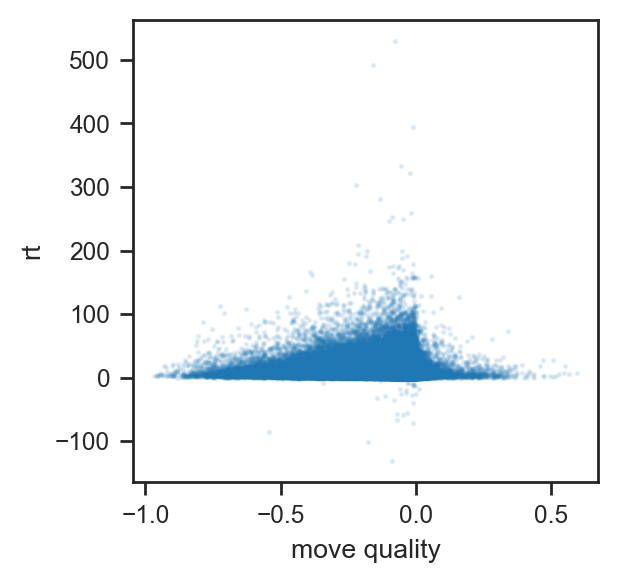

In [76]:
fig,ax = plt.subplots(1, figsize=(3,3), dpi=200)
ax.plot(res_df[this_col], res_df.rt, 'o', ms=1, alpha=.1)#, yerr = agg_df['rt']['std']/np.sqrt(agg_df['rt']['count']), label = '{}'.format(depth_number - 1))
ax.set_ylabel('rt')
ax.set_xlabel('move quality')

Text(0, 0.5, 'move quality')

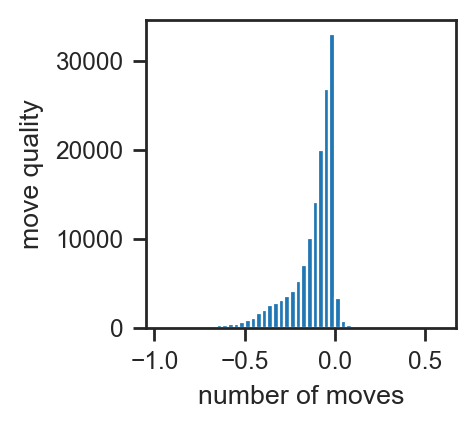

In [92]:
fig,ax = plt.subplots(1, figsize=(2,2), dpi=200)
ax.hist(res_df[this_col], bins=50);
ax.set_xlabel('number of moves')
ax.set_ylabel('move quality')

In [84]:
?plt.hist

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*.  The return value is a tuple
(*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
*patches1*, ...]) if the input contains multiple data.  See the
documentation of the *weights* parameter to draw a histogram of
already-binned data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported.

The *bins*, *range*, *weights*, and *density* parameters behave as in
`numpy.histogram`.

P